<a href="https://colab.research.google.com/github/janscharf/PC-T-GAN/blob/main/PC_T_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Downloads

##Downloads

In [ ]:
!pip install uproot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.2/742.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.4/706.4 kB 24.1 MB/s eta 0:00:00


##Imports

In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import uproot
from tqdm import tqdm
drive.mount('/content/gdrive/')
sys.path.insert(0, '/content/gdrive/MyDrive/Uni/MA')

Mounted at /content/gdrive/


#Defining Classes

## Transformer Block Class

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
  def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
    """
    embed_dim must be the same as input.shape[0]
    """
    super(TransformerBlock, self).__init__()
    self.num_heads = num_heads
    self.key_dim = key_dim
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim
    self.dropout_rate = dropout_rate
    self.attn = tf.keras.layers.MultiHeadAttention(num_heads, key_dim, output_shape=embed_dim)
    self.dropout_1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.ln_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.ffn_1 = tf.keras.layers.Dense(self.ff_dim, activation="relu")
    self.ffn_2 = tf.keras.layers.Dense(self.embed_dim)
    self.dropout_2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.ln_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.con = tf.keras.layers.Concatenate()

  def call(self, inputs):
    print(inputs.shape)
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    attention_output= self.attn(inputs, inputs)
    #attention_output, attention_scores = self.attn(inputs, inputs, return_attention_scores=True)
    attention_output = self.dropout_1(attention_output)
    #conc = self.con([inputs, attention_output])
    out1 = self.ln_1(inputs+attention_output)
    ffn_1 = self.ffn_1(out1)
    ffn_2 = self.ffn_2(ffn_1)
    ffn_output = self.dropout_2(ffn_2)
    #conc2 = self.con([out1, ffn_output])
    #return (self.ln_2(out1 + ffn_output), attention_scores)
    return self.ln_2(out1 + ffn_output)

## Wasserstein-GAN with Gradient Penalty Class

In [ ]:
class WGANGP(tf.keras.models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight, N_amount_dist, N_prob_dist):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight
        self.x_shape = 1024
        self.y_shape = 1024
        self.z_shape = 24
        self.interpolate_im = 0
        self.N_amount_dist = N_amount_dist
        self.N_prob_dist = N_prob_dist
        self.batch_size = 0
        self.latent_mean = 0
        self.latent_stddev = 1

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = tf.keras.metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = tf.keras.metrics.Mean(name="c_gp")
        self.c_loss_metric = tf.keras.metrics.Mean(name="c_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def pc_to_im(self, pc):
        im = tf.zeros(shape=(self.x_shape, self.y_shape, self.z_shape))
        X = pc[:,0]
        Y = pc[:,1]
        Z = pc[:,2]
        E = pc[:,3]
        for i in range(X.shape[0]):
          im[X[i], Y[i], Z[i]] = E[i]
        return im


    def interpolate(self, batch_size, fake_images, real_images):
        fim = self.pc_to_im(fake_images[0])
        rim = self.pc_to_im(real_images[0])
        alpha = tf.random.normal((1,), 0, 1)
        iim_list = rim * (1 - alpha) + alpha * fim
        tf.expand_dim(iim_list, axis=0)
        for i in range(1, batch_size):
          fim = self.pc_to_im(fake_images[i])
          rim = self.pc_to_im(real_images[i])
          alpha = tf.random.normal((1,), 0, 1)
          iim = rim * (1 - alpha) + alpha * fim
          tf.expand_dim(iim, axis=0)
          iim_list = tf.concat([iim_list, iim], axis=0)
        self.interpolate_im = iim_list

    def im_to_pc_with_yield(self):
        for i in range(self.interpolate_im.shape[0]):
          im = self.interpolate_im[i]
          x_list = []
          y_list = []
          z_list = []
          E_list = []
          for x in range(self.x_shape):
            for y in range(self.y_shape):
              for z in range(self.z_shape):
                if im[x,y,z] != 0 :
                  x_list.append(x)
                  y_list.append(y)
                  z_list.append(z)
                  E_list.append(im[x,y,z])
          x_tensor = tf.convert_to_tensor(x_list)
          y_tensor = tf.convert_to_tensor(y_list)
          z_tensor = tf.convert_to_tensor(z_list)
          E_tensor = tf.convert_to_tensor(E_list)
          tf.expand_dims(x_tensor, axis=-1)
          tf.expand_dims(y_tensor, axis=-1)
          tf.expand_dims(z_tensor, axis=-1)
          tf.expand_dims(E_tensor, axis=-1)
          pc = tf.concat([x_tensor, y_tensor, z_tensor, E_tensor], axis=-1)
          yield pc

    def gradient_penalty(self, batch_size, real_images, fake_images):
        self.interpolate(batch_size, fake_images, real_images)
        interpolated = tf.data.Dataset.from_generator(self.im_to_pc_with_yield, output_types=tf.float32, output_shapes=(None, 4))

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp


    def create_fake_images(self):
        i = 0
        while i < self.batch_size:
          N = np.random.choice(self.N_amount_dist, p=self.N_prob_dist)
          fake_im = tf.random.normal(shape=(N, self.latent_dim), mean=self.latent_mean, stddev = self.latent_stddev)
          if tf.raw_ops.UniqueV2(x=t3, axis=[0]).shape[0]==N:
            i+=1
            yield fake_im


    def train_step(self, real_images):
        self.batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.data.Dataset.from_generator(self.create_fake_images, output_types=tf.float32, output_shapes=(None, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    self.batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.data.Dataset.from_generator(self.create_fake_images, output_types=tf.float32, output_shapes=(None, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

## Dataset Generator Class

In [34]:
class dataset_generator():
    def __init__(self, root_data_path, batch_size, normalize_data):
      self.data = root_data_path
      actual_path = self.data + ":CaloOutputWriter/Frames"
      file = uproot.open(actual_path)
      self.rows = file["row"].array(library="np")
      self.columns = file["column"].array(library="np")
      self.lanes = file["lane"].array(library="np")
      self.nHits = file["nHits"].array(library="np")
      self.layer_shape = 24 #layer
      self.col_shape = 1024 #col
      self.row_shape = 1024 #row
      self.layer_shape_reduced = 6
      self.col_shape_reduced = 32
      self.row_shape_reduced = 32
      self.normalize_data = normalize_data
      self.batch_size = batch_size

    def test(self):
      print("Test")

    def change_to_real_coordinates_for_one_event(self, layer, row, col):
      """
  	  This function changes the lane, row, col to its actual coordinates. It takes lane, row, col as input at ouputs
      layer, row, col for one event.
      """
      def lane2layer(lane):
        const={40:22,39:22,42:20,41:20,44:18,43:18,46:16,45:16,
            48:14,47:14,50:12,49:12,52:10,51:10,54: 8,53: 8,
            38: 6,55: 6,36: 4,37: 4,32: 0,35: 0,34: 2,33: 2,
            64:23,63:23,66:21,65:21,68:19,67:19,70:17,69:17,
            72:15,71:15,74:13,73:13,76:11,75:11,78: 9,77: 9,
            62: 7,79: 7,60: 5,61: 5,56: 1,59: 1,58: 3,57: 3}
        return const[lane]

      def lane2chipid(lane):
        const2={40: 0,39: 1,42: 2,41: 3,44: 4,43: 5,46: 6,45: 7,
            48: 8,47: 9,50:10,49:11,52:12,51:13,54:14,53:15,
            38:16,55:17,36:18,37:19,32:20,35:21,34:22,33:23,
            64:24,63:25,66:26,65:27,68:28,67:29,70:30,69:31,
            72:32,71:33,74:34,73:35,76:36,75:37,78:38,77:39,
            62:40,79:41,60:42,61:43,56:44,59:45,58:46,57:47}
        return const2[lane]

      def layer2isInv(layerNr):
        if layerNr%2==1:
            return True
        else:
            return False

      def IsLeftChip(lane):
        layerNr=lane2layer(lane)
        isInv = layer2isInv(layerNr)
        chipid= lane2chipid(lane)
        if chipid%2 ==1:
          isOdd=True
        else:
          isOdd=False
        if isOdd!=isInv:
          return True
        else:
          return False

      def checkforsides(lane, row, col):
        if not IsLeftChip(lane):
            col= 1023-col
            row= -row-1+512
        else:
            row=row+512
        layer= lane2layer(lane)
        return layer, row, col

      for i in range(layer.shape[0]):
        layer[i], row[i], col[i]=checkforsides(layer[i], row[i], col[i])
      return layer, row, col

    def pc_to_im(self, layer, row, col, reduced=False):
      """
      This function turns a point cloud into an image matrix, the size of the image depends if it is reduced or not. The image
      has the shape (layer, row, col) and so does the point cloud.
      """
      if not reduced:
        im = np.zeros(shape=(self.layer_shape, self.row_shape, self.col_shape))
      elif reduced:
        im = np.zeros(shape=(self.layer_shape_reduced, self.row_shape_reduced, self.col_shape_reduced))
      for i in range(layer.shape[0]):
        im[layer[i], row[i], col[i]] = 1    #because no value can be given to at tf tensor
      return tf.convert_to_tensor(im)

    def im_to_pc(self, image, reduced=False):
      """
      This function turns a image matrix into a point cloud, the size of the image depends if it is reduced or not. The image
      has the shape (layer, row, col). It returns the point cloud coordinates of layer, row, col seperatly.
      """
      layer_list = []
      row_list = []
      col_list = []
      if reduced:
        layer_shape_ac, row_shape_ac, col_shape_ac = self.layer_shape_reduced, self.row_shape_reduced, self.col_shape_reduced
      if not reduced:
        layer_shape_ac, row_shape_ac, col_shape_ac = self.layer_shape, self.row_shape, self.col_shape
      #print(layer_shape_ac, row_shape_ac, col_shape_ac)
      for x in range(layer_shape_ac):
        for y in range(row_shape_ac):
          for z in range(col_shape_ac):
            if image[x,y,z] != 0 :
                  layer_list.append(x)
                  row_list.append(y)
                  col_list.append(z)
      return layer_list, row_list, col_list

    def create_reduce_model(self):
      """
      creates the model that reduces the size of the data.
      """
      input = tf.keras.Input(shape=(24, 1024, 1024, 1))
      x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(input)
      x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
      out = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
      reduce_model = tf.keras.Model(inputs=input, outputs=out, name="reduce_model")
      return reduce_model


    def train_generator(self):
      """
      This function is the generator for the train_dataset which includes the non-reduced data.
      """
      for i in range(self.nHits.shape[0]):
        layer, row, col = self.change_to_real_coordinates_for_one_event(self.lanes[i], self.rows[i], self.columns[i])
        layer = tf.expand_dims(tf.convert_to_tensor(layer, dtype=tf.int32), axis=-1)
        row = tf.expand_dims(tf.convert_to_tensor(row, dtype=tf.int32), axis=-1)
        col = tf.expand_dims(tf.convert_to_tensor(col, dtype=tf.int32), axis=-1)
        E = tf.expand_dims(tf.ones(shape=(self.nHits[i],), dtype=tf.int32), axis=-1)
        if self.normalize_data:
          row = row/self.row_shape
          col = col/self.col_shape
          layer = layer/self.layer_shape
          data = tf.concat([layer, row, col, E], axis=-1)
        yield data

    def train_generator_reduced(self):
      """
      This function is the generator for the train_dataset which consists of the reduced data.
      """
      reduce_model = self.create_reduce_model()
      for i in range(self.nHits.shape[0]):
        layer, row, col = self.change_to_real_coordinates_for_one_event(self.lanes[i], self.rows[i], self.columns[i])
        image = self.pc_to_im(layer, row, col, False)
        image = tf.expand_dims(image, axis=-1)
        image = tf.expand_dims(image, axis=0)
        reduce_image = reduce_model(image)
        reduce_image = tf.squeeze(reduce_image)
        layre, row, col = self.im_to_pc(reduce_image, True)
        layer = tf.expand_dims(tf.convert_to_tensor(layer, dtype=tf.int32), axis=-1)
        row = tf.expand_dims(tf.convert_to_tensor(row, dtype=tf.int32), axis=-1)
        col = tf.expand_dims(tf.convert_to_tensor(col, dtype=tf.int32), axis=-1)
        E = tf.expand_dims(tf.ones(shape=(layer.shape[0],), dtype=tf.int32), axis=-1)
        if self.normalize_data:
          row = row/self.row_shape_reduced
          col = col/self.col_shape_reduced
          layer = layer/self.layer_shape_reduced
        data = tf.concat([layer, row, col, E], axis=-1)
        yield data


    def create_train_dataset(self, reduced=False):
      """
      This function creates the train_datasets using either the non-reduced data generator or the reduced data generator.
      """
      if reduced:
        dataset = tf.data.Dataset.from_generator(self.train_generator_reduced, output_types=tf.int32, output_shapes=(None, 4))
        print("The dataset consist of reduced images.")
      else:
        dataset = tf.data.Dataset.from_generator(self.train_generator, output_types=tf.int32, output_shapes=(None, 4))
        print("The dataset consist of original images.")
      #dataset = tf.data.Dataset.from_generator(self.train_generator, output_signature=(tf.RaggedTensorSpec(shape=(None, 4), dtype=tf.int32)))
      dataset = dataset.shuffle(40).padded_batch(self.batch_size)#, drop_remainder=True)
      return dataset

    def N_prob_dist(self):
      """
      This function calculates the probability of a specific amount of hits, based on the ditribution of nHits.
      """
      N_amount_dist, N_prob_dist = np.unique(self.nHits, return_counts=True)
      N_prob_dist = N_prob_dist/np.sum(N_prob_dist)
      return N_amount_dist, N_prob_dist

    def N_prob_dist_reduced(self):
      """
      This function gets the prior calculated probability of a specific amount of hits of the reduced dataset.
      """
      data = np.genfromtxt("/content/gdrive/MyDrive/Uni/BA/GNN/GAN/nHits_low_res_distribution_real.csv", delimiter=",")
      N_amount_dist, N_prob_dist = data[:,0], data[:,1]
      return N_amount_dist, N_prob_dist

    def plot_one_example(self, path, title="Example Event", reduced=False, i=0):
      """
      This function plots an example point cloud and saves it to path.
      """
      if i >= self.lanes.shape[0]:
        i = 0
      layer, row, col = self.change_to_real_coordinates_for_one_event(self.lanes[i], self.rows[i], self.columns[i])
      layer_shape_ac, row_shape_ac, col_shape_ac = self.layer_shape, self.row_shape, self.col_shape
      if reduced:
          reduce_model = self.create_reduce_model()
          image = self.pc_to_im(layer, row, col, False)
          #print(layer)
          image = tf.expand_dims(image, axis=0)
          image = tf.expand_dims(image, axis=-1)
          #print(image.shape)
          reduce_image = reduce_model(image)
          #print(reduce_image.shape)
          reduce_image = tf.squeeze(reduce_image)
          #print(reduce_image.shape)
          layer, row, col = self.im_to_pc(reduce_image, True)
          layer, row, col = np.asarray(layer), np.asarray(row), np.asarray(col)
          layer_shape_ac, row_shape_ac, col_shape_ac = self.layer_shape_reduced, self.row_shape_reduced, self.col_shape_reduced
      subplot3d = plt.subplot(111, projection='3d')
      subplot3d.axes.set_xlim3d(left=0, right=col_shape_ac)
      subplot3d.axes.set_ylim3d(bottom=0, top=row_shape_ac)
      subplot3d.axes.set_zlim3d(bottom=0, top=layer_shape_ac)
      subplot3d.set_xlabel('columns', fontweight = 'bold', fontsize=15)
      subplot3d.set_ylabel('rows', fontweight = 'bold', fontsize=15)
      subplot3d.set_zlabel('layers', fontweight = 'bold', fontsize=15)
      my_cmap = plt.get_cmap('hsv')
      scatter = subplot3d.scatter(col, row, layer, c=layer, cmap=my_cmap, s=1)
      #print(layer)
      #print(row)
      #print(col)
      #add colorbar on the left
      #cbar = plt.colorbar(scatter, shrink=0.5, aspect=5)
      #cbar.set_label('layers', rotation=90, labelpad=15, fontsize=15, fontweight = 'bold')
      #subplot3d.set_title(title, fontsize=20)
      plt.savefig(path, dpi=300)
      print("Event "+ title + " was plotted and saved to " + path + " .")

#Test Code

In [30]:
gen = dataset_generator("/content/gdrive/MyDrive/Uni/MA/gps3_E20_spread0.3GeV_halfBox8mmAir_t25.1_nch50_d5_pixelThr82_noise20_stepLength1.root", 5, False)

Event Example Event was plotted and saved to /content/im.png .


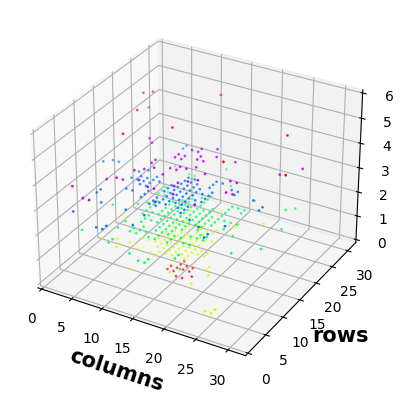

In [31]:
gen.plot_one_example("/content/im.png", reduced=True)

In [33]:
train_dataset = gen.create_train_dataset(False)
N, P = gen.N_prob_dist()
plt.plot(N, P)
N, P = gen.N_prob_dist_reduced()
plt.plot(N, P)
gen.test()

The dataset consist of original images.


AttributeError: 'dataset_generator' object has no attribute 'nHits_counted'

In [ ]:
# ffn layer is felxible to input points as it only works on the later layers
input = tf.keras.Input(shape=(None, 4), dtype="int32")
x = tf.keras.layers.Dense(4, "relu", name="first")(input)
print(x.shape)
x = TransformerBlock(2, 6, 4, 30)(x)
output = tf.keras.layers.Dense(4, name="last")(x)
model = tf.keras.Model(inputs=input, outputs=output)
model.summary()
model.predict(train_dataset)#, batch_size=5)

(None, None, 4)
(None, None, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 first (Dense)               (None, None, 4)           20        
                                                                 
 transformer_block (Transfo  (None, None, 4)           522       
 rmerBlock)                                                      
                                                                 
 last (Dense)                (None, None, 4)           20        
                                                                 
Total params: 562 (2.20 KB)
Trainable params: 562 (2.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(None, None, 4)
     13/Unknown - 14s 603ms/step

KeyboardInterrupt: 

In [ ]:
t3 = tf.constant([[1,2,3],[4,5,6],[4,5,6]])

#print(tf.slice(t3, begin=[0, 0, 0],size=[1, :, :]))
print(tf.raw_ops.UniqueV2(x=t3, axis=[0]))


In [ ]:
print(train_dataset.take(1))

<_TakeDataset element_spec=TensorSpec(shape=(None, None, 4), dtype=tf.int32, name=None)>


In [ ]:
input = tf.keras.Input(shape=(24, 1024, 1024, 1))
x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(input)
x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
x = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
out = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
reduce_model = tf.keras.Model(inputs=input, outputs=out)
reduce_model.summary()

file = uproot.open("/content/gdrive/MyDrive/Uni/MA/gps3_E20_spread0.3GeV_halfBox8mmAir_t25.1_nch50_d5_pixelThr82_noise20_stepLength1.root:CaloOutputWriter/Frames")
rows = file["row"].array(library="np")
columns = file["column"].array(library="np")
lanes = file["lane"].array(library="np")
nHits = file["nHits"].array(library="np")
#nHits_counted = []

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 1024, 1024,   0         
                              1)]                                
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 12, 512, 512, 1)   0         
 ng3D)                                                           
                                                                 
 max_pooling3d_37 (MaxPooli  (None, 6, 256, 256, 1)    0         
 ng3D)                                                           
                                                                 
 max_pooling3d_38 (MaxPooli  (None, 6, 128, 128, 1)    0         
 ng3D)                                                           
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 6, 64, 64, 1)      0   

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5]
[ 9 18 23 23 23 24 24 24 24 24 25 25 25 25 25 26 26 27 27  7 11 17 18 18
 18 19 20 20 20 2

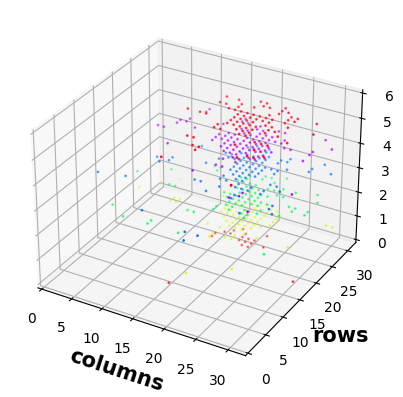

In [ ]:
i = 3
layer, row, col = gen.change_to_real_coordinates_for_one_event(lanes[i], rows[i], columns[i])
im = np.zeros(shape=(24, 1024, 1024))
for j in range(layer.shape[0]):
  im[layer[j], row[j], col[j]] = 1
im = tf.convert_to_tensor(im)
im = tf.expand_dims(im, axis=-1)
im = tf.expand_dims(im, axis=0)
reduced_im = reduce_model(im)
reduced_im = tf.squeeze(reduced_im)
layer_list = []
row_list = []
col_list = []
layer_shape_ac, row_shape_ac, col_shape_ac = 6, 32, 32
for x in range(layer_shape_ac):
  for y in range(row_shape_ac):
    for z in range(col_shape_ac):
      if reduced_im[x,y,z] != 0 :
        layer_list.append(x)
        row_list.append(y)
        col_list.append(z)
layer = np.asarray(layer_list)
row = np.asarray(row_list)
col = np.asarray(col_list)
subplot3d = plt.subplot(111, projection='3d')
subplot3d.axes.set_xlim3d(left=0, right=col_shape_ac)
subplot3d.axes.set_ylim3d(bottom=0, top=row_shape_ac)
subplot3d.axes.set_zlim3d(bottom=0, top=layer_shape_ac)
subplot3d.set_xlabel('columns', fontweight = 'bold', fontsize=15)
subplot3d.set_ylabel('rows', fontweight = 'bold', fontsize=15)
subplot3d.set_zlabel('layers', fontweight = 'bold', fontsize=15)
my_cmap = plt.get_cmap('hsv')
scatter = subplot3d.scatter(col, row, layer, c=layer, cmap=my_cmap, s=1)
print(layer)
print(row)
print(col)